In [1]:
# ==========================================
# 1. Imports & Paths
# ==========================================

from pathlib import Path
import json
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# --- Paths ---
NB_DIR = Path.cwd()
DATA_DIR = (NB_DIR / "../data").resolve()
RES_DIR  = (NB_DIR / "../results").resolve()   # use results/ for now
RES_DIR.mkdir(parents=True, exist_ok=True)

CLEAN_CSV = DATA_DIR / "chess_games_clean.csv"

print("Data dir:", DATA_DIR)
print("Results dir:", RES_DIR)
print("Clean dataset:", CLEAN_CSV)

# --- Sklearn / classical ML ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib

# --- Deep learning (TensorFlow/Keras) ---
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs available:", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(RANDOM_STATE)

# --- Sequence preprocessing ---
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences

# --- Plotting ---
import matplotlib.pyplot as plt
import seaborn as sns

Data dir: E:\Github Projects\chess-outcome-prediction\data
Results dir: E:\Github Projects\chess-outcome-prediction\results
Clean dataset: E:\Github Projects\chess-outcome-prediction\data\chess_games_clean.csv
TensorFlow version: 2.16.1
Num GPUs available: 0


In [2]:
# ==========================================
# 2. Load Dataset & Train/Val/Test Split
# ==========================================

# Load cleaned dataset
df = pd.read_csv(CLEAN_CSV)
print("Dataset shape:", df.shape)
display(df.head(3))

# Separate target
y = df["target"]

# Drop target + sequence column for numeric features
drop_text = [c for c in ["moves_first15_san"] if c in df.columns]
X_num = df.drop(columns=["target"] + drop_text).select_dtypes(include=[np.number])

print("Numeric features shape:", X_num.shape)

# Encode target
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Save label encoder for later
joblib.dump(le, RES_DIR / "label_encoder.joblib")

# Split into train/val/test (stratified)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_num, y_enc, test_size=0.3, stratify=y_enc, random_state=RANDOM_STATE
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Target classes:", list(le.classes_))

Dataset shape: (119868, 30)


,white_rating,black_rating,rating_diff,avg_rating,white_pawns,black_pawns,white_knights,black_knights,white_bishops,black_bishops,white_rooks,black_rooks,white_queens,black_queens,white_material_value,black_material_value,material_balance_white_minus_black,side_to_move_is_white,white_can_castle_kingside,white_can_castle_queenside,black_can_castle_kingside,black_can_castle_queenside,white_centre_control,black_centre_control,white_mobility_legal_moves,black_mobility_legal_moves,captures_in_first_15_moves,checks_in_first_15_moves,plies_processed,target
0,1812,1803,9,1807.5,5,6,2,1,2,2,2,2,1,1,36,34,2,1,0,0,1,0,4,4,48,46,6,0,30,white
1,1840,1791,49,1815.5,6,7,2,1,1,2,2,2,1,1,34,35,-1,1,0,0,0,0,1,3,46,29,5,2,28,white
2,2193,1782,411,1987.5,8,7,1,1,1,2,2,2,1,1,33,35,-2,1,0,0,0,0,4,3,37,31,4,0,30,black


Numeric features shape: (119868, 29)
Train: (83907, 29) Val: (17980, 29) Test: (17981, 29)
Target classes: ['black', 'draw', 'white', nan]


Numeric features: 29
First 10 feature names: ['white_rating', 'black_rating', 'rating_diff', 'avg_rating', 'white_pawns', 'black_pawns', 'white_knights', 'black_knights', 'white_bishops', 'black_bishops']
Train class counts:
black    38730
draw      3248
white    41912
NaN          0
Val class counts:
black    8299
draw      696
white    8981
NaN         0
Test class counts:
black    8300
draw      696
white    8982
NaN         0
Class weights used (by encoded id): {0: 0.5416150271107668, 2: 0.500495084939874, 1: 12.916717980295566, 3: 1233.9264705882354}
OOB score (approx generalisation): 0.6497074141609163
RF — Train Acc: 0.9034 | Train F1(macro): 0.9148
RF — Val   Acc: 0.6520   | Val   F1(macro): 0.3560
RF — Test  Acc: 0.6515  | Test  F1(macro): 0.3453
Saved report → E:\Github Projects\chess-outcome-prediction\results\rf_report.json


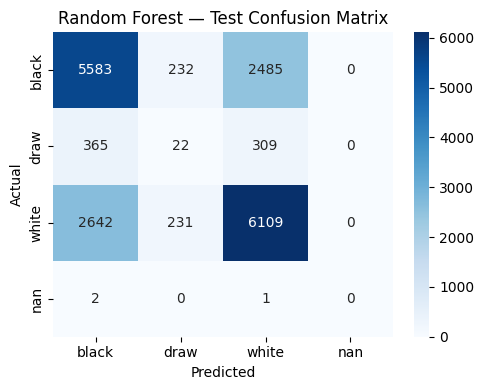

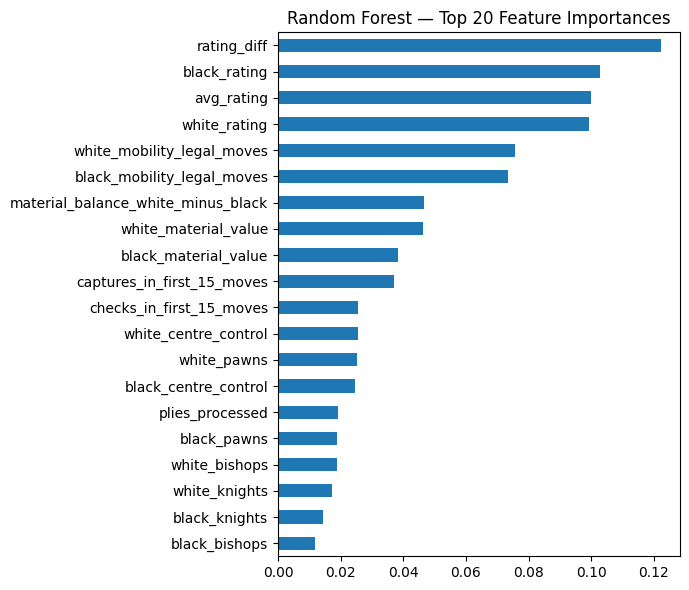

In [7]:
# ==========================================
# 3. Baseline: Random Forest (classical) — tuned
# ==========================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import json, os
import numpy as np
import pandas as pd

# ---- Inspect training data / feature space ----
print("Numeric features:", X_train.shape[1])
print("First 10 feature names:", list(X_train.columns[:10]))

def show_distribution(y_enc, name):
    inv = le.inverse_transform(y_enc)
    vc = pd.Series(inv).value_counts().reindex(le.classes_, fill_value=0)
    print(f"{name} class counts:")
    print(vc.to_string())

show_distribution(y_train, "Train")
show_distribution(y_val,   "Val")
show_distribution(y_test,  "Test")

# ---- Class weights (balanced + slight draw boost) ----
# base weights = inverse freq; then upweight 'draw' by x2 to help recall
counts = Counter(y_train)
n_samples = sum(counts.values())
n_classes = len(le.classes_)
base_w = {cls: n_samples / (n_classes * cnt) for cls, cnt in counts.items()}

# find encoded id for "draw" (if present)
draw_id = None
for idx, name in enumerate(le.classes_):
    if name.lower() == "draw":
        draw_id = idx
        break
if draw_id is not None:
    base_w[draw_id] = base_w[draw_id] * 2.0  # boost draws
print("Class weights used (by encoded id):", base_w)

# ---- Model (slightly regularised to reduce overfitting) ----
rf = RandomForestClassifier(
    n_estimators=400,          # a bit smaller for speed/size, still strong
    max_depth=24,             # limit depth to curb overfit
    max_features="sqrt",      # common good default
    min_samples_split=6,
    min_samples_leaf=3,
    class_weight=base_w,      # our custom weights with draw boost
    bootstrap=True,
    oob_score=True,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

rf.fit(X_train, y_train)
print("OOB score (approx generalisation):", getattr(rf, "oob_score_", None))

# ---- Eval helper ----
def eval_rf(model, Xtr, ytr, Xva, yva, Xte, yte, class_names):
    preds_tr = model.predict(Xtr)
    preds_va = model.predict(Xva)
    preds_te = model.predict(Xte)

    out = {
        "train": {"acc": accuracy_score(ytr, preds_tr),
                  "f1_macro": f1_score(ytr, preds_tr, average="macro")},
        "val":   {"acc": accuracy_score(yva, preds_va),
                  "f1_macro": f1_score(yva, preds_va, average="macro")},
        "test":  {"acc": accuracy_score(yte, preds_te),
                  "f1_macro": f1_score(yte, preds_te, average="macro"),
                  "report": classification_report(yte, preds_te, target_names=class_names, output_dict=True),
                  "confusion_matrix": confusion_matrix(yte, preds_te).tolist()},
    }
    return out

rf_report = eval_rf(rf, X_train, y_train, X_val, y_val, X_test, y_test, list(le.classes_))
print(f"RF — Train Acc: {rf_report['train']['acc']:.4f} | Train F1(macro): {rf_report['train']['f1_macro']:.4f}")
print(f"RF — Val   Acc: {rf_report['val']['acc']:.4f}   | Val   F1(macro): {rf_report['val']['f1_macro']:.4f}")
print(f"RF — Test  Acc: {rf_report['test']['acc']:.4f}  | Test  F1(macro): {rf_report['test']['f1_macro']:.4f}")

# ---- Save report only (keep repo light) ----
with open(RES_DIR / "rf_report.json", "w", encoding="utf-8") as f:
    json.dump(rf_report, f, indent=2)
print("Saved report →", RES_DIR / "rf_report.json")

# ---- Confusion matrix (test) ----
cm = np.array(rf_report["test"]["confusion_matrix"])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Random Forest — Test Confusion Matrix")
plt.tight_layout()
plt.savefig(RES_DIR / "rf_confusion_matrix.png", dpi=150)
plt.show()

# ---- Feature importances (top 20) ----
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)
plt.figure(figsize=(7, 6))
importances[::-1].plot(kind="barh")
plt.title("Random Forest — Top 20 Feature Importances")
plt.tight_layout()
plt.savefig(RES_DIR / "rf_feature_importances_top20.png", dpi=150)
plt.show()